In [20]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob # path 读取指定路径下的特有格式的文件
import os

import torch
import unicodedata
import string

In [21]:
all_letters = string.ascii_letters + " .,;'-"
print(all_letters)
n_letters = len(all_letters) + 1 # Plus EOS marker
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-
59


In [22]:
# 统一为英文
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii("O'Néàl"))

O'Neal


In [23]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [24]:
category_lines = {}
all_categories = []
def findFiles(path):
    return glob.glob(path)

print('======= filepath ========')
print(findFiles('data/names/*.txt'))
print('======= end filepath ========\n\n')

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    # print(category)
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('# categories: ', n_categories, all_categories)

======= filepath ========
['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
======= end filepath ========


# categories:  18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [25]:
print(category_lines['Arabic'])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad', 'Najjar', 'Dagher', 'Maloof', 'Isa', 'Asghar', 'Nader', 'Gaber', 'Abboud', 'Maalouf', 'Zogby', 'Srour', 'Bahar', 'Mustafa', 'Hanania', 'Daher', 'Tuma', 'Nahas', 'Saliba', 'Shamoon', 'Handal', 'Baba', 'Amari', 'Bahar', 'Atiyeh', 'Said', 'Khouri', 'Tahan', 'Baba', 'Mustafa', 'Guirguis', 'Sleiman', 'Seif', 'Dagher', 'Bahar', 'Gaber', 'Harb', 'Seif', 'Asker', 'Nader', 'Antar', 'Awad', 'Srour', 'Shadid', 'Hajjar', 'Hanania', 'Kalb', 'Shadid', 'Bazzi', 'Mustafa', 'Masih', 'Ghanem', 'Haddad', 'Isa', 'Antoun', 'Sarraf', 'Sleiman', 'Dagher', 'Najjar', 'Malouf', 'Nahas', 'Naser', 'Saliba', 'Shamon', 'Malouf', 'Kalb', 'Daher', 'Maalouf', 'Wasem', 'Kanaan', 'Naifeh', 'Boutros', 'Moghadam', 'Masih', 'Sleiman', 'Aswad', 'Cham', 'Assaf', 'Quraishi', 'Shalhoub', 'Sabbag', 'Mifsud', 'Gaber', 'Shammas', 'Tannous', 'Sleiman', 'Bazzi', 'Quraishi', 'Rahal', 'Ch

In [26]:
# 获取数据
import random

# 列表中的随机项
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    # 随机抽取语言
    category = randomChoice(all_categories)
    # 对该语言随机抽取名字
    line = randomChoice(category_lines[category])
    return category, line

In [27]:
# 类别的独热编码
def categoryTensor(category):
    li = all_categories.index(category) # 获取该语言索引
    # 构造one-hot
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 对于ABC这样的字符串
# 构造(A,B),(B,C)...的序列
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)# 1 batch 一个个输进去所以默认batch为1
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 用于目标的第二个结束字母（EOS）的LongTensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)
# Alt Al  lt  t<EOS>

In [28]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [29]:
import torch.nn as nn
import torch

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        # i2h input → hidden语义 语言+单词+语义
        # i2o input → output输出 output_size = input_size
        # o2o output  单词+语义 单词
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i20 = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1) # 过拟合
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i20(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [30]:
# 定义模型
rnn = RNN(n_letters, 128, n_letters)

n_iters = 10000
print_every = 500
plot_every = 200
all_losses = []
total_loss = 0 # Reset every plot_every iters

criterion = nn.NLLLoss()
learning_rate = .0005

In [31]:

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [32]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [33]:
start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 1s (500 5%) 3.9196
0m 3s (1000 10%) 3.2807
0m 4s (1500 15%) 3.4905
0m 6s (2000 20%) 2.7046
0m 7s (2500 25%) 2.7767
0m 9s (3000 30%) 3.1652
0m 10s (3500 35%) 3.0162
0m 12s (4000 40%) 3.2084
0m 13s (4500 45%) 3.0284
0m 16s (5000 50%) 2.9599
0m 19s (5500 55%) 2.9464
0m 21s (6000 60%) 2.7530
0m 24s (6500 65%) 2.5494
0m 26s (7000 70%) 2.5623
0m 28s (7500 75%) 2.2483
0m 31s (8000 80%) 2.7690
0m 38s (8500 85%) 2.4285
0m 46s (9000 90%) 2.7186
0m 51s (9500 95%) 3.0439
0m 53s (10000 100%) 3.5393


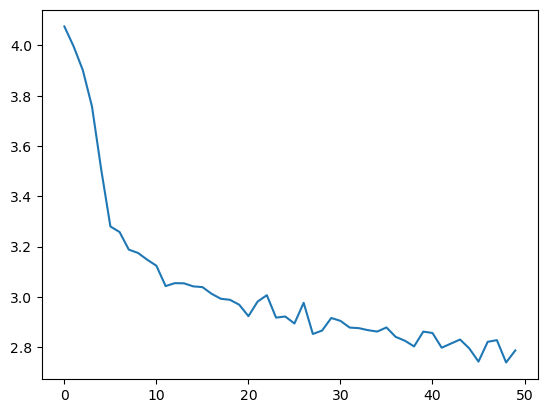

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

In [35]:
max_length = 20

# 来自类别和首字母的样本
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:#<EOS>
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# 从一个类别和多个起始字母中获取多个样本
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rane
Uara
Sane
Gare
Eara
Rarer
San
Pan
Aaner
Con
Har
Ian
